In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.optimize import fsolve

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Parameters
n_sub = 1.5 # Refractive index outside
n_core = 3.5  # Core refractive index
n_clad = 1.5 # Cladding refractive index
d = 1.5e-6  # Thickness in meters
wavelength = 1.55e-6  # Wavelength in meters

In [4]:
# Constants
k0 = 2 * np.pi / wavelength  # Free space wave number
V = k0 * d * np.sqrt(n_core ** 2 - n_clad ** 2)  # Normalized frequency for given parameters
print(f"V = {round(V, 3)}")

V = 19.228


In [5]:
# Characteristic equations for TE modes
def characteristic_TE(b, V, n_core, n_clad, n_sub, N):
    a = (n_clad ** 2 - n_sub ** 2) / (n_core ** 2 - n_clad ** 2)
    lhs = np.arctan(np.sqrt(max(b, 0) / max(1 - b, 1e-9))) + np.arctan(np.sqrt(max(b + a, 0) / max(1 - b, 1e-9)))
    rhs = V * np.sqrt(max(1 - b, 0)) - np.pi * N
    return lhs - rhs

In [6]:
# Corrected characteristic equation for TM modes
def characteristic_TM(b, V, n_core, n_clad, n_sub, N):
    a = (n_clad ** 2 - n_sub ** 2) / (n_core ** 2 - n_clad ** 2)
    lhs = (np.arctan((n_core**2 / n_clad**2) * np.sqrt(max(b, 0) / max(1 - b, 1e-9))) +
           np.arctan((n_core**2 / n_sub**2) * np.sqrt(max(b + a, 0) / max(1 - b, 1e-9))))
    rhs = V * np.sqrt(max(1 - b, 0)) - np.pi * N
    return lhs - rhs


### Why is the Number of Modes $M = \frac{V}{\pi}$?

The normalized frequency parameter $V$ determines the number of modes a waveguide can support. It is defined as:

$$
V = \frac{2 \pi}{\lambda} d \sqrt{n_2^2 - n_3^2}
$$

where:
- $d$: Core thickness.
- $\lambda$: Wavelength.
- $n_2$: Core refractive index.
- $n_3$: Cladding refractive index.

#### Mode Existence in the Waveguide:
For a mode $N$ to exist, the **characteristic equation** for TE or TM modes must have a solution. This imposes the condition:

$$
V \sqrt{1 - b} = \pi N + \text{phase correction terms}.
$$

Here:
- $b = \frac{\beta^2 - k_0^2 n_3^2}{k_0^2 (n_2^2 - n_3^2)}$: Normalized propagation constant.
- $N$: Mode index.

The number of modes $M$ corresponds to the largest $N$ such that $V > \pi N$, because each mode requires $V > \pi N$ for a valid solution. Therefore:

$$
M = \left\lfloor \frac{V}{\pi} \right\rfloor + 1
$$

In general, $M \approx \frac{V}{\pi}$ gives a good approximation of the number of modes.

---

In [7]:
# Solve for b for both TE and TM modes at specific V 
max_modes = int(np.floor(V / np.pi)) + 1  # Number of modes (N=0, 1, 2)
print(f"Number of modes: {max_modes}")
b_te = []
b_tm = []

Number of modes: 7


In [8]:
initial_b = [0.9999999 - N * 0.005 for N in range(max_modes)]

for N in range(max_modes):
    try:
        # Solve for TE modes
        b_te_solution = fsolve(characteristic_TE, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
        if 0 < b_te_solution < 1:
            b_te.append((N, b_te_solution))
        else:
            b_te.append((N, None))

        # Solve for TM modes with corrected equation
        b_tm_solution = fsolve(characteristic_TM, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
        if 0 < b_tm_solution < 1:
            b_tm.append((N,b_tm_solution))
        else:
            b_tm.append((N, None))
    except:
        print(f"Error solving for mode N={N}: {e}")
        b_te.append((N, None))
        b_tm.append((N, None))


In [9]:
# Compute effective indices (n_eff) for each b value
n_eff_te = [np.sqrt(b[1] * (n_core ** 2 - n_clad ** 2) + n_clad ** 2) if b[1] is not None else None for b in
            b_te]
n_eff_tm = [np.sqrt(b[1] * (n_core ** 2 - n_clad ** 2) + n_clad ** 2) if b[1] is not None else None for b in
            b_tm]

In [10]:
# Print results for TE and TM modes
print("TE Modes:")
for N, b, neff in zip(range(max_modes), b_te, n_eff_te):
    print(f"Mode N={N},\t b={b[1]:.5},\tn_eff={neff:.5}")

TE Modes:
Mode N=0,	 b=0.97811,	n_eff=3.4686
Mode N=1,	 b=0.91264,	n_eff=3.3729
Mode N=2,	 b=0.80421,	n_eff=3.2081
Mode N=3,	 b=0.65409,	n_eff=2.965
Mode N=4,	 b=0.46481,	n_eff=2.6264
Mode N=5,	 b=0.24231,	n_eff=2.1617
Mode N=6,	 b=0.014353,	n_eff=1.5471


In [11]:
print("TM Modes:")
for N, b, neff in zip(range(max_modes), b_tm, n_eff_tm):
     print(f"Mode N={N},\t b={b[1]:.5},\tn_eff={neff:.5}")

TM Modes:
Mode N=0,	 b=0.97431,	n_eff=3.4631
Mode N=1,	 b=0.8974,	n_eff=3.3502
Mode N=2,	 b=0.76985,	n_eff=3.1541
Mode N=3,	 b=0.59317,	n_eff=2.8604
Mode N=4,	 b=0.37187,	n_eff=2.4431
Mode N=5,	 b=0.128,	n_eff=1.8788
Mode N=6,	 b=0.0011638,	n_eff=1.5039


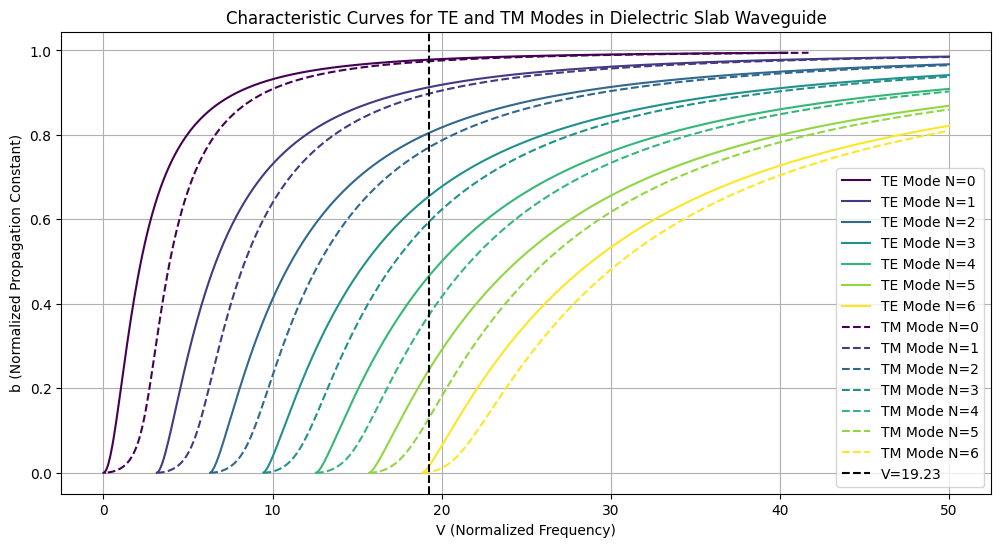

In [12]:
# Plot characteristic curves for TE and TM modes over a range of V
V_range = np.linspace(0.01, 50, 1000)  # Avoid V=0 for stability
b_values_te = {N: [fsolve(characteristic_TE, 0.5, args=(V, n_core, n_clad, n_sub, N))[0]
                   if 0 < fsolve(characteristic_TE, 0.5, args=(V, n_core, n_clad, n_sub, N))[0] < 1 else np.nan
                   for V in V_range] for N in range(max_modes)}

b_values_tm = {N: [fsolve(characteristic_TM, 0.5, args=(V, n_core, n_clad, n_sub, N))[0]
                   if 0 < fsolve(characteristic_TM, 0.5, args=(V, n_core, n_clad, n_sub, N))[0] < 1 else np.nan
                   for V in V_range] for N in range(max_modes)}

# Plot results
plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, max_modes))  # Dynamically create unique colors

# TE Modes
for N in range(max_modes):
    plt.plot(V_range, b_values_te[N], label=f"TE Mode N={N}", linestyle='-', color=colors[N])

# TM Modes
for N in range(max_modes):
    plt.plot(V_range, b_values_tm[N], label=f"TM Mode N={N}", linestyle='--', color=colors[N])

# Highlight V
plt.axvline(V, color='black', linestyle='--', label=f"V={V:.2f}")

plt.xlabel("V (Normalized Frequency)")
plt.ylabel("b (Normalized Propagation Constant)")
plt.title("Characteristic Curves for TE and TM Modes in Dielectric Slab Waveguide")
plt.legend()
plt.grid()
plt.show()

### Why is $V_{\text{cutoff}} = \pi$ for Single-Mode Operation?

Single-mode operation implies that only the fundamental mode ($N = 0$) is supported. For the $N = 0$ mode, the cutoff condition is when the next mode ($N = 1$) is about to appear, i.e., the normalized frequency $V$ satisfies:

$$
\pi N \leq V < \pi (N + 1) \quad \text{for } N = 0
$$

Thus:
$$
V_{\text{cutoff}} = \pi
$$

At this value, only the $N = 0$ mode exists, and higher-order modes do not yet appear. 


In [13]:
c = 3* 1e8  # Speed of light in m/s
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)

In [14]:
def calculate_wavelength(V, d, n1, n2):
    """Calculate the wavelength for a given normalized frequency V."""
    return (2 * np.pi * d * np.sqrt(n2**2 - n1**2)) / V

In [15]:
V = np.pi  # From the graphical representation for TE0 cutoff

wavelength = calculate_wavelength(V, d, n_clad, n_core)
print(f"Shortest wavelength for single TE mode: {wavelength * 1e6:.2f} um")

k0 = 2 * np.pi / wavelength  # Free space wavenumber
omega = 2 * np.pi * c / wavelength  # Angular frequency

Shortest wavelength for single TE mode: 9.49 um


# Symmetric Characteristic Equation and Normalized TE0 Mode

In a symmetric dielectric slab waveguide, the **characteristic equation** for the TE0 mode is:

$$
\frac{1}{2} h d \cdot \tan\left(\frac{h d}{2}\right) = \frac{1}{2} p d
$$

In [16]:
p = lambda beta: np.sqrt(beta**2 - (n_clad * k0)**2)  # Decay constant in cladding
h = lambda beta: np.sqrt((n_core * k0)**2 - beta**2)  # Propagation constant in core

In [17]:
def solve_beta(beta):
    """Solve the characteristic equation for TE0."""
    hd = h(beta) * d
    pd = p(beta) * d
    return (hd / 2) * np.tan(hd / 2) - pd / 2

In [18]:
beta_initial_guess = n_core * k0 - 1e3  # Close to n_core*k0
beta_solution = fsolve(solve_beta, beta_initial_guess)[0]

# Calculate h and p using beta
h_value = h(beta_solution)
p_value = p(beta_solution)

- **Core** ($0 < x < d$): 
 $$
 E(x) = \cos\left(h \cdot (x - d/2)\right)/\cos\left(h \cdot(d/2\right))
 $$
- **Cladding**:
 $$
 E(x) = 
 \begin{cases} 
 E(0) \cdot e^{p (x - d/2)}, & x < 0 \\
 E(d) \cdot e^{-p (x - d/2)}, & x > d
 \end{cases}
 $$

In [19]:
x = np.linspace(-d, 2 * d, 1000)  # Include regions outside the core
field_profile = np.zeros_like(x)

# Core region (0 < x < d)
core_region = (x >= 0) & (x <= d)
field_profile[core_region] = (
    np.cos(h_value * (x[core_region] - d / 2)) / np.cos(h_value * d / 2)
) * np.exp(-p_value * d / 2) 

left_cladding = x < 0
field_profile[left_cladding] = np.exp(
    p_value * (x[left_cladding] - d / 2)
) 

right_cladding = x > d
field_profile[right_cladding] = np.exp(
    -p_value * (x[right_cladding] - d/2)
) 

To ensure the field is physically meaningful, the profile must satisfy the normalization condition:

$$
\int_{-\infty}^\infty |E_y|^2 dx = \frac{2 \omega \mu}{\beta}
$$


In [20]:
dx = x[1] - x[0]
integral = np.trapz(np.abs(field_profile) ** 2, dx=dx) 
normalization_factor = np.sqrt(2 * omega * mu0 / (beta_solution * integral))
field_profile *= normalization_factor

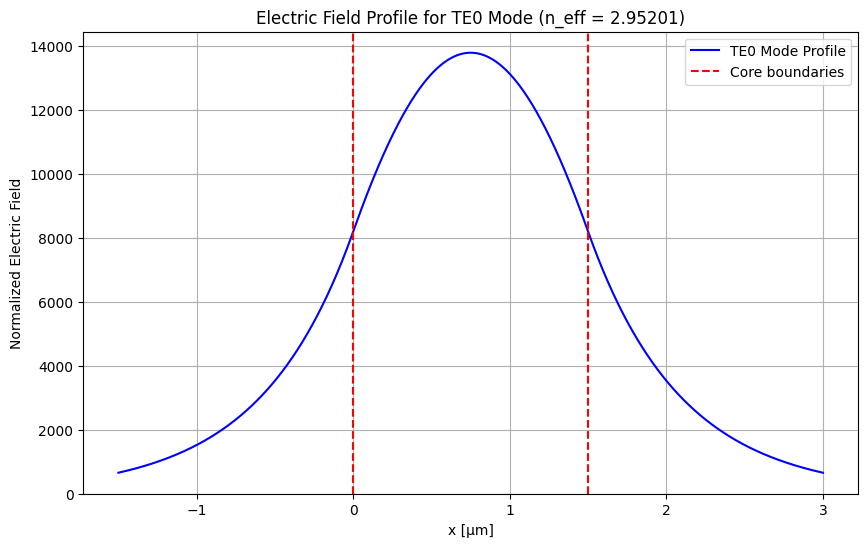

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(x * 1e6, field_profile, label="TE0 Mode Profile", color="blue")
plt.axvline(0, color='red', linestyle='--', label="Core boundaries")
plt.axvline(d * 1e6, color='red', linestyle='--')
plt.title(f"Electric Field Profile for TE0 Mode (n_eff = {beta_solution/k0:.5f})")
plt.xlabel("x [µm]")
plt.ylabel("Normalized Electric Field")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print(f"Wavelength (λ): {wavelength:.5e} m")
print(f"Propagation constant (β): {beta_solution:.5e} m^-1")
print(f"n effective: {beta_solution / k0:.5e}")
print(f"h (core propagation constant): {h_value:.5e} m^-1")
print(f"p (cladding decay constant): {p_value:.5e} m^-1")

Wavelength (λ): 9.48683e-06 m
Propagation constant (β): 1.95513e+06 m^-1
n effective: 2.95201e+00
h (core propagation constant): 1.24535e+06 m^-1
p (cladding decay constant): 1.68392e+06 m^-1
